In [1]:
#Descarregar segm_eliret.zip
url='http://www.lps.usp.br/hae/apostila/segm_eliret.zip'
import os; nomeArq=os.path.split(url)[1]
if not os.path.exists(nomeArq):
  print("Baixando o arquivo",nomeArq,"para diretorio default",os.getcwd())
  os.system("wget -nc -U 'Firefox/50.0' "+url)
else:
  print("O arquivo",nomeArq,"ja existe no diretorio default",os.getcwd())
print("Descompactando arquivos novos de",nomeArq)
os.system("unzip -u "+nomeArq)

Baixando o arquivo segm_eliret.zip para diretorio default /content
Descompactando arquivos novos de segm_eliret.zip


0

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                      

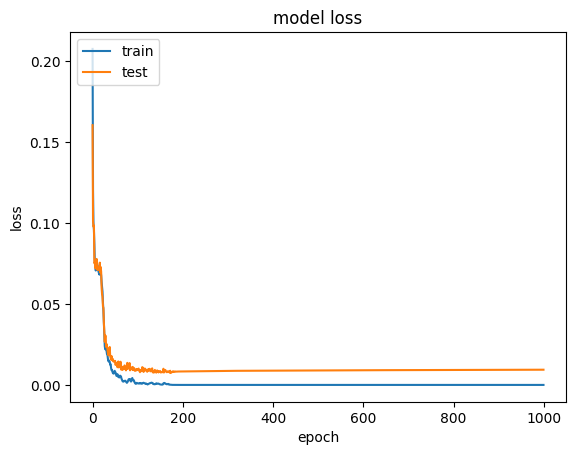

Training loss: 1.3503738127695897e-09
Validation loss: 0.00939095951616764
Test loss: 0.008675693534314632


In [2]:
#unet-train1.py
#Treina rede unet para segmentacao semantica de eliret
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import cv2; import numpy as np; np.random.seed(7); import sys
import tensorflow.keras as keras; from tensorflow.keras.models import *
from tensorflow.keras.layers import *; from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt

def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def leCsv(nomeDir,nomeArq):
  print("Lendo: ",nomeArq); arq=open(os.path.join(nomeDir,nomeArq),"r")
  lines=arq.readlines(); arq.close(); n=len(lines)

  nl,nc = 32,32
  AX=np.empty((n,nl,nc),dtype='uint8'); AY=np.empty((n,nl,nc),dtype='uint8')
  i=0
  for linha in lines:
    linha=linha.strip('\n'); linha=linha.split(';')
    AX[i]=cv2.imread(os.path.join(nomeDir,linha[0]),0)
    AY[i]=cv2.imread(os.path.join(nomeDir,linha[1]),0)
    i=i+1

  ax= np.float32(AX)/255.0; ay= np.float32(AY)/255.0 #Entre 0 e +1
  ax = ax.reshape(n, nl, nc, 1); ay = ay.reshape(n, nl, nc, 1)
  return ax, ay

def unet(input_size = (32,32,1)):
  n=32
  inputs = Input(input_size) #32x32
  conv2 = Conv2D(n, 3, activation = 'relu', padding = 'same' )(inputs)
  conv2 = Conv2D(n, 3, activation = 'relu', padding = 'same' )(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  #16x16

  conv3 = Conv2D(2*n, 3, activation = 'relu', padding = 'same' )(pool2) #16x16
  conv3 = Conv2D(2*n, 3, activation = 'relu', padding = 'same' )(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  #8x8

  conv4 = Conv2D(4*n, 3, activation = 'relu', padding = 'same' )(pool3) #8x8
  conv4 = Conv2D(4*n, 3, activation = 'relu', padding = 'same' )(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)  #4x4

  conv5 = Conv2D(8*n, 3, activation = 'relu', padding = 'same' )(pool4) #4x4
  conv5 = Conv2D(8*n, 3, activation = 'relu', padding = 'same' )(conv5) #4x4

  up6 = Conv2D(4*n, 2, activation = 'relu', padding = 'same'
              )(UpSampling2D(size = (2,2))(conv5)) #8x8
  merge6 = concatenate([conv4,up6], axis = 3) #8x8
  conv6 = Conv2D(4*n, 3, activation = 'relu', padding = 'same' )(merge6)
  conv6 = Conv2D(4*n, 3, activation = 'relu', padding = 'same' )(conv6) #8x8

  up7 = Conv2D(2*n, 2, activation = 'relu', padding = 'same'
              )(UpSampling2D(size = (2,2))(conv6)) #16x16
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(2*n, 3, activation = 'relu', padding = 'same' )(merge7)
  conv7 = Conv2D(2*n, 3, activation = 'relu', padding = 'same' )(conv7) #16x16

  up8 = Conv2D(n, 2, activation = 'relu', padding = 'same'
              )(UpSampling2D(size = (2,2))(conv7)) #32x32
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(n, 3, activation = 'relu', padding = 'same' )(merge8)
  conv8 = Conv2D(n, 3, activation = 'relu', padding = 'same' )(conv8) #32x32x32

  conv9 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same' )(conv8) #32x32

  model = Model(inputs = inputs, outputs = conv9)
  model.compile(optimizer = Adam(learning_rate=1e-3), loss = 'mean_squared_error')
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file='unet-train1.png', show_shapes=True)
  model.summary()
  return model

#<<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
bdDir = "."
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "."; os.chdir(outDir)

#Escolha entre comecar treino do zero ou continuar o treino de onde parou
model=unet()
#model = load_model("unet1.h5");

history=model.fit(ax, ay, batch_size=10, epochs=1000, verbose=2, validation_data=(vx,vy));
impHistoria(history); model.save("unet1.h5");

score = model.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0); print('Test loss:', score)

1/1 [==============================] - 0s 487ms/step


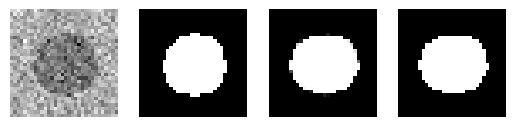

In [3]:
#unet-pred1.py
#Faz segmentacao de elipses e retangulos usando rede gerada pelo unet-train1.py
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import cv2; import numpy as np; np.random.seed(7)
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys; from sys import argv

#<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<
bdDir = "."
outDir = "."; os.chdir(outDir)
nome="077"
inImgX = nome+"x.png"; inImgY = nome+"y.png"
outImgG =nome+"g.png"; outImgB =nome+"b.png"
arquivoRede = "unet1.h5"

model = load_model(os.path.join(outDir,arquivoRede))
QX=cv2.imread(os.path.join(bdDir,inImgX),0)
QY=cv2.imread(os.path.join(bdDir,inImgY),0)
nl=QX.shape[0]; nc=QX.shape[1]
qx=np.float32(QX)/255.0 #Entre 0 e +1
qx=qx.reshape(1, nl, nc, 1)

qp=model.predict(qx); qp=qp.reshape(nl,nc) # entre 0 e +1

QPG=255.0*qp; QPG=np.clip(QPG,0,255) # Entre 0 e 255
QPG=np.uint8(QPG); cv2.imwrite(os.path.join(outDir,outImgG),QPG)

QPB=np.zeros((nl,nc),dtype='uint8'); QPB[ qp>=0.5 ] = 255
cv2.imwrite(os.path.join(outDir,outImgB),QPB)

from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1,4,1); plt.imshow(QX,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,2); plt.imshow(QY,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,3); plt.imshow(QPG,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,4); plt.imshow(QPB,cmap="gray"); plt.axis('off')
plt.show(block=True)

(-0.5, 31.5, 31.5, -0.5)

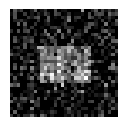

In [4]:
ax[12].mean()
ay[13].max()

img1=ax[1].reshape( nl, nc)

f = plt.figure()
f.add_subplot(1,4,1); plt.imshow(img1,cmap="gray"); plt.axis('off')